# Approach 2: Background estimation
For this approach, we consider a time series of motion (and lapse) images, i.e. all images in the serious are close together in time (here +- 10 min).

We extract the median image by taking the median of every pixel over all images in the series. Then, for every image the absolute difference to the median image is computed. As in the previous approach, we assume that anomalous images highly differ from the median image.

The median image is used as a (possibly more accurate) approximation of the background instead of the closest lapse image.

### Advantages compared to approach 1a
- more resistent to noise
- more resistent to small object movements
- only sensitive to camera movement within the time series

### Problems
- still no color information
- the lighting difference within the series are still a problem

In [14]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn.linear_model import LogisticRegression

from py.PlotUtils import plot_roc_curve
from py.Dataset import Dataset
from py.ImageUtils import display_images
from py.Labels import LABELS

DIR = './ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("beaver_01")
append_lapse_image = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 2 sessions
Session 'Beaver_01' at folder: ./ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


In [2]:
img_set = session.get_random_motion_image_set(day_only=True)
if append_lapse_image:
    before, after, rel = img_set[0].get_closest_lapse_images()
    if rel < 0.15:
        img_set.append(before)
    if rel > 0.85:
        img_set.append(after)
print(f"{len(img_set)} images in set")

Generating motion map...
7 images in set


In [3]:
# Read all images
imgs = []
for img in tqdm(img_set):
    arr = img.read(gray=True)
    # normalize
    # arr = (arr - np.mean(arr)) / np.std(arr)
    imgs.append(arr)
imgs = np.array(imgs)

  0%|          | 0/7 [00:00<?, ?it/s]

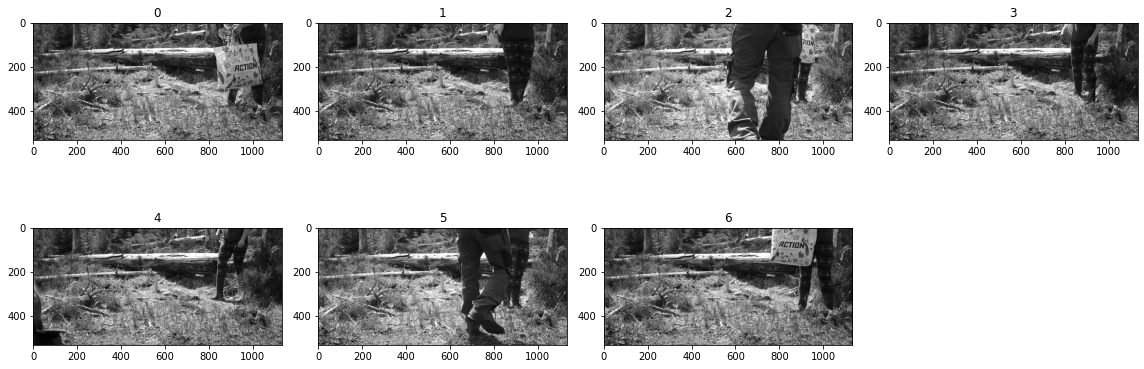

In [4]:
display_images(imgs, range(len(imgs)), row_size=4, size=(4, 3), cmap="gray", vmin=0, vmax=1)

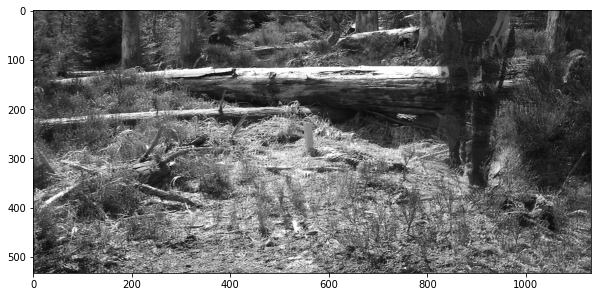

In [5]:
# Find median image
median = np.median(imgs, axis=0)
plt.figure(figsize=(10, 8))
plt.imshow(median, cmap="gray", vmin=0, vmax=1)

In [6]:
diffs = abs(imgs - median)

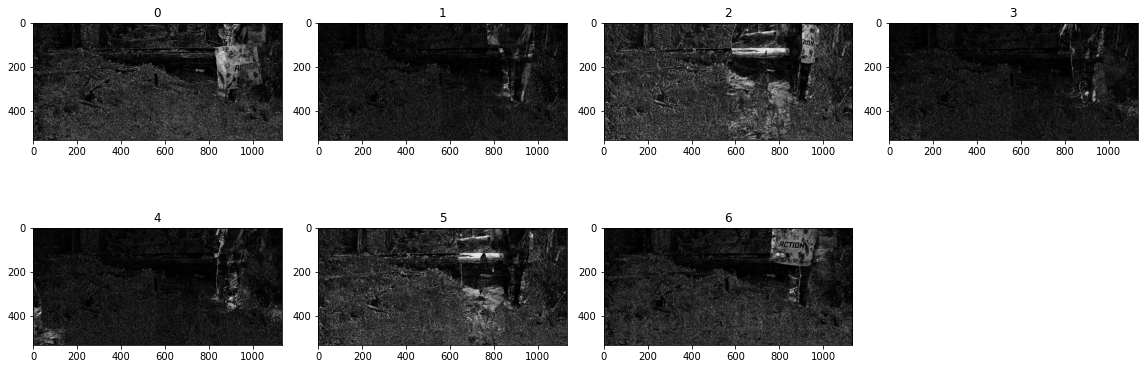

In [7]:
display_images(diffs, range(len(diffs)), row_size=4, size=(4, 3), cmap="gray", vmin=0, vmax=1)

## Complete test

In [8]:
results = []

for img_set in session.generate_motion_image_sets():
    # Optionally append a close lapse image
    if append_lapse_image:
        before, after, rel = img_set[0].get_closest_lapse_images()
        if rel < 0.15:
            img_set.append(before)
        if rel > 0.85:
            img_set.append(after)
        print(f"{len(img_set)} images in set")
    
    # Read all images
    imgs = []
    for img in tqdm(img_set):
        arr = img.read(gray=True)
        # normalize
        # arr = (arr - np.mean(arr)) / np.std(arr)
        imgs.append(arr)
    imgs = np.array(imgs)

    # Find median image, calculate diffs
    median = np.median(imgs, axis=0)
    diffs = (imgs - median) ** 2
    means = np.mean(diffs, axis=(1,2))
    vars = np.var(diffs, axis=(1,2))
    for img, mean, var in zip(img_set, means, vars):
        results.append([img.filename, mean, var])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
np.save(f"Cache_NoBackup/approach2_{session.name}_results.npy", results)

In [10]:
results = np.load(f"Cache_NoBackup/approach2_{session.name}_results.npy")
results

array([['Beaver_01_00001.jpg', '0.03157315058171535',
        '0.008842501879227922'],
       ['Beaver_01_00002.jpg', '0.01590260488964755',
        '0.004257656931850018'],
       ['Beaver_01_00003.jpg', '0.005390408061453107',
        '0.00032305310691840193'],
       ...,
       ['Beaver_01_00693.jpg', '0.06754646257597216',
        '0.012471854739153881'],
       ['Beaver_01_00694.jpg', '0.055833027874570236',
        '0.008597549614760561'],
       ['Beaver_01_00695.jpg', '0.07819557309669879',
        '0.009699179824057685']], dtype='<U22')

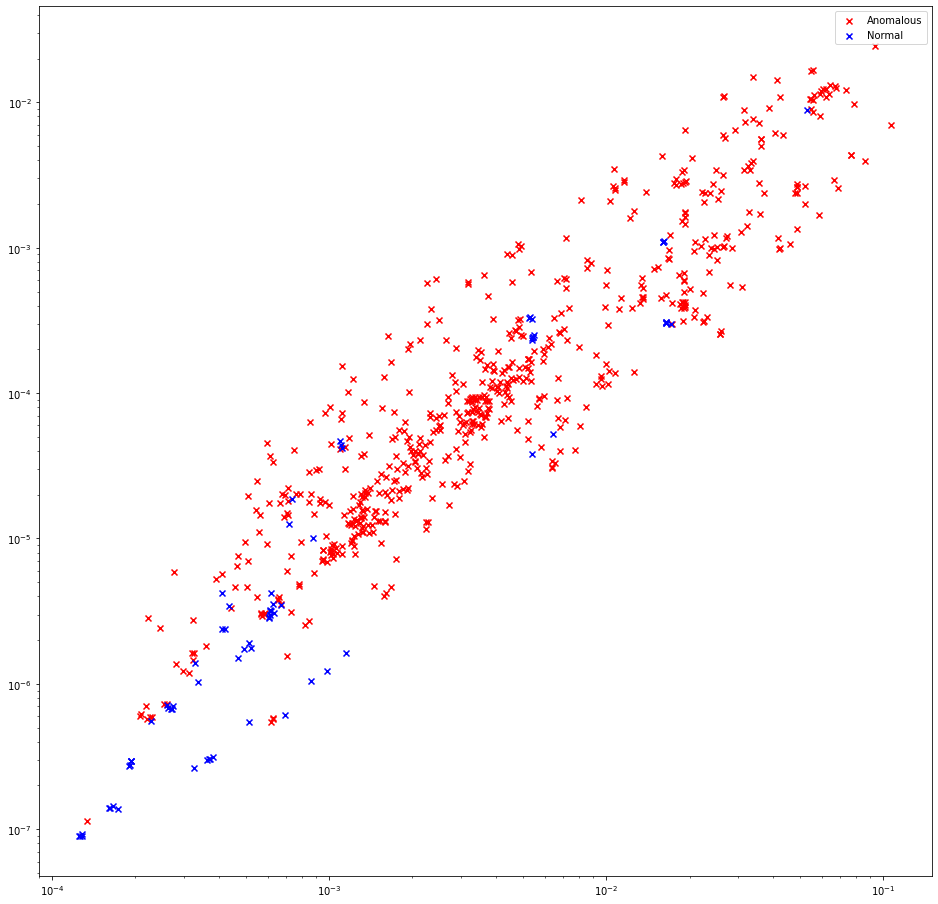

In [11]:
normal = []
anomalous = []
for filename, mean, var in results:
    vals = [float(mean), float(var)]
    if filename.startswith(session.name):
        # motion img, check label
        img_nr = int(filename[10:-4])
        if img_nr > LABELS[session.name]["max"]:
            continue
        elif img_nr in LABELS[session.name]["normal"]:
            normal.append(vals)
        else:
            anomalous.append(vals)
    else:
        # lapse image, always normal
        normal.append(vals)
normal = np.array(normal)
anomalous = np.array(anomalous)

plt.figure(figsize=(16,16))
plt.scatter(anomalous[:,0], anomalous[:,1], label="Anomalous", color="red", marker="x")
plt.scatter(normal[:,0], normal[:,1], label="Normal", color="blue", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [12]:
y_anom = anomalous
assert y_anom.shape[1] == 2

y_norm = normal
assert y_norm.shape[1] == 2

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(695, 2)
(695,)


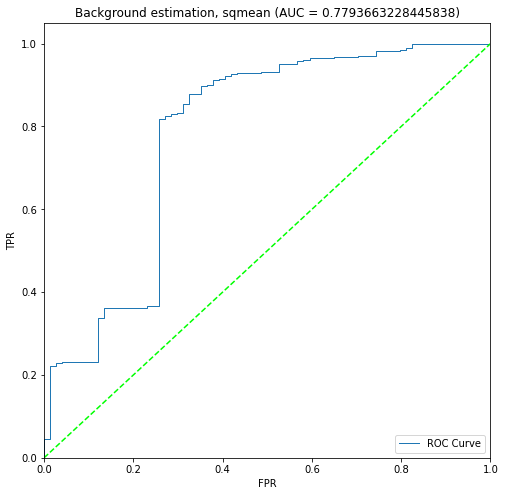

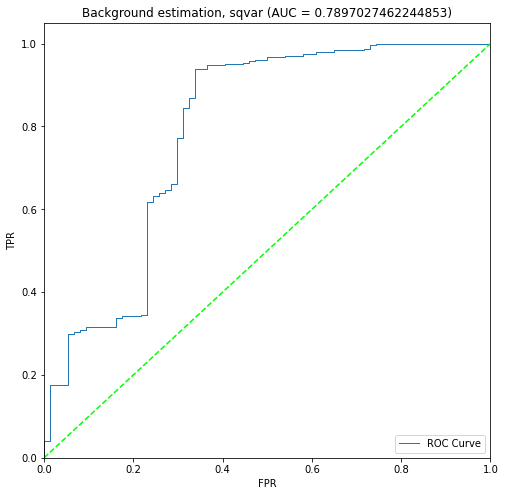

In [13]:
vals = ["sqmean", "sqvar"]
for i in range(2):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Background estimation, {vals[i]}", savefile=f"plots/approach2/roc_curves/{session.name}_{vals[i]}", show=False)

## Experiment 2: Add Gaussian filter
Two orders possible:
- 1. Gaussian filter images, 2. Calculate median image
- 1. Calculate median image, 2. Gaussian filter images + median image

Experiments show that order 1 yields better results.

In [40]:
sigma = 6
results = []

for img_set in session.generate_motion_image_sets():
    # Optionally append a close lapse image
    if append_lapse_image:
        before, after, rel = img_set[0].get_closest_lapse_images()
        if rel < 0.15:
            img_set.append(before)
        if rel > 0.85:
            img_set.append(after)
        print(f"{len(img_set)} images in set")
    
    # Read all images
    imgs = []
    for img in tqdm(img_set):
        arr = img.read(gray=True)
        # normalize
        # arr = (arr - np.mean(arr)) / np.std(arr)
        imgs.append(arr)
    imgs = np.array(imgs)

    # filter images
    for i in range(len(imgs)):
        imgs[i] = ndimage.gaussian_filter(imgs[i], sigma=sigma)

    # Find median image
    median = np.median(imgs, axis=0)

    # calculate diffs
    diffs = (imgs - median) ** 2
    means = np.mean(diffs, axis=(1,2))
    vars = np.var(diffs, axis=(1,2))
    for img, mean, var in zip(img_set, means, vars):
        results.append([img.filename, mean, var])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
np.save(f"Cache_NoBackup/approach2_{session.name}_sigma{sigma}_results.npy", results)

In [42]:
results = np.load(f"Cache_NoBackup/approach2_{session.name}_sigma{sigma}_results.npy")
results

array([['Beaver_01_00001.jpg', '0.014280600080679788',
        '0.0020734794305921735'],
       ['Beaver_01_00002.jpg', '0.008288921832863205',
        '0.0008510550557174119'],
       ['Beaver_01_00003.jpg', '0.0012486121280961902',
        '4.416768547282191e-05'],
       ...,
       ['Beaver_01_00693.jpg', '0.04721488717203606',
        '0.007299481326703805'],
       ['Beaver_01_00694.jpg', '0.03638954703417264',
        '0.004612428821338789'],
       ['Beaver_01_00695.jpg', '0.05964926270407911',
        '0.004056385288080761']], dtype='<U22')

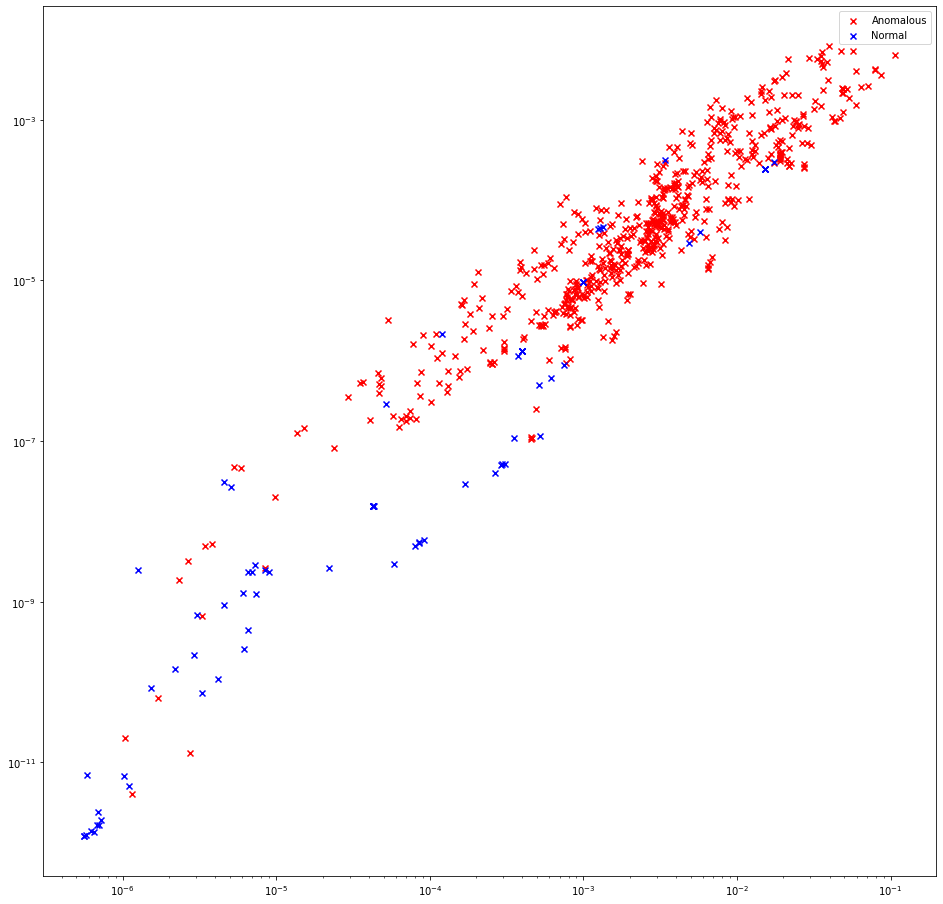

In [43]:
normal = []
anomalous = []
for filename, mean, var in results:
    vals = [float(mean), float(var)]
    if filename.startswith(session.name):
        # motion img, check label
        img_nr = int(filename[10:-4])
        if img_nr > LABELS[session.name]["max"]:
            continue
        elif img_nr in LABELS[session.name]["normal"]:
            normal.append(vals)
        else:
            anomalous.append(vals)
    else:
        # lapse image, always normal
        normal.append(vals)
normal = np.array(normal)
anomalous = np.array(anomalous)

plt.figure(figsize=(16,16))
plt.scatter(anomalous[:,0], anomalous[:,1], label="Anomalous", color="red", marker="x")
plt.scatter(normal[:,0], normal[:,1], label="Normal", color="blue", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [44]:
y_anom = anomalous
assert y_anom.shape[1] == 2

y_norm = normal
assert y_norm.shape[1] == 2

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(695, 2)
(695,)


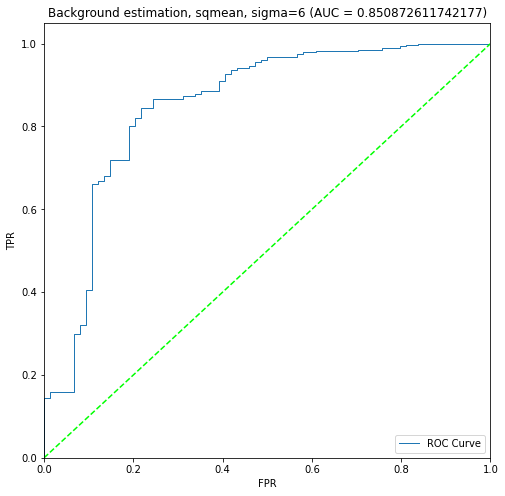

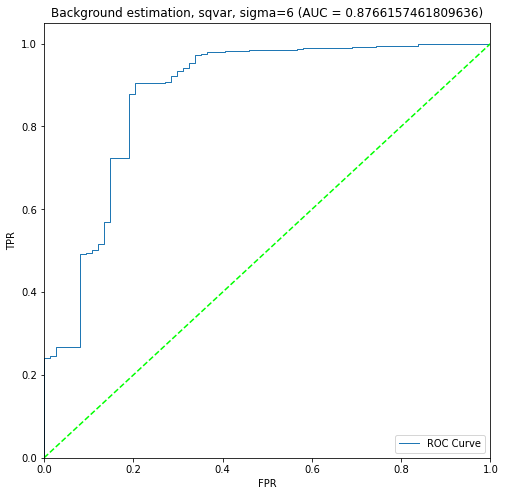

In [45]:
vals = ["sqmean", "sqvar"]
for i in range(2):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Background estimation, {vals[i]}, sigma={sigma}", savefile=f"plots/approach2/roc_curves/{session.name}_{vals[i]}_sigma{sigma}", show=False)